In [ ]:
pip install SimpleITK

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import SimpleITK as sitk
import cv2
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data Loading and Preprocessing


Defining paths and loading the dataset.

Getting lists of subset images files.

Combining file lists and removing duplicates.

Defining functions to create masks (RECTANGULAR PATCHES) and retrieve filenames.

Loading annotations and mapping series UIDs to filenames.

Constructing a DataFrame with image data, mask data, and class labels.

In [ ]:
import numpy as np
import pandas as pd
import SimpleITK as sitk
from glob import glob
from tqdm import tqdm

# Define paths and load the dataset
file_path_0 = "/content/drive/MyDrive/Image Processing/LUNA/subsets/subset0"
file_path_1 = "/content/drive/MyDrive/Image Processing/LUNA/subset1/subset1"
annotations_path = "/content/drive/MyDrive/Image Processing/LUNA/annotations.csv"

# Getting list of image files from both subsets
file_list_0 = glob(file_path_0 + "/*.mhd")
file_list_1 = glob(file_path_1 + "/*.mhd")

# Combine file lists and remove duplicates
file_list = list(set(file_list_0 + file_list_1))

# Function to make rectangular mask
def make_rectangular_mask(center, diam, z, width, height, spacing, origin):
    mask = np.zeros([height, width], dtype=np.uint8)
    v_center = (center - origin) / spacing
    v_xmin = int(v_center[0] - diam / spacing[0] / 2)
    v_xmax = int(v_center[0] + diam / spacing[0] / 2)
    v_ymin = int(v_center[1] - diam / spacing[1] / 2)
    v_ymax = int(v_center[1] + diam / spacing[1] / 2)

    # Ensure the coordinates are within the image boundaries
    v_xmin = max(v_xmin, 0)
    v_xmax = min(v_xmax, width - 1)
    v_ymin = max(v_ymin, 0)
    v_ymax = min(v_ymax, height - 1)

    mask[v_ymin:v_ymax, v_xmin:v_xmax] = 1

    return mask

# Function to get filename
def get_filename(file_list, case):
    for f in file_list:
        if case in f:
            return f

# Load annotations
df_node = pd.read_csv(annotations_path)
df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(file_list, file_name))
df_node = df_node.dropna()

# Define DataFrame columns
columns = ["seriesuid", "sliceindex", "imagedata", "maskdata", "class"]
data = []

for img_file in tqdm(file_list):
    mini_df = df_node[df_node["file"] == img_file]
    if mini_df.shape[0] > 0:
        itk_img = sitk.ReadImage(img_file)
        img_array = sitk.GetArrayFromImage(itk_img)
        num_z, height, width = img_array.shape
        origin = np.array(itk_img.GetOrigin())
        spacing = np.array(itk_img.GetSpacing())

        for _, row in mini_df.iterrows():
            node_x, node_y, node_z = row["coordX"], row["coordY"], row["coordZ"]
            diam = row["diameter_mm"]
            center = np.array([node_x, node_y, node_z])
            v_center = np.rint((center - origin) / spacing)
            i_z = int(v_center[2])

            masks = np.zeros((num_z, height, width), dtype=np.uint8)
            mask = make_rectangular_mask(center, diam, i_z * spacing[2] + origin[2], width, height, spacing, origin)
            masks[i_z] = mask

            classes = np.zeros(num_z, dtype=np.uint8)
            classes[i_z] = 1

            for idx in range(num_z):
                data.append([row["seriesuid"], idx, img_array[idx], masks[idx], classes[idx]])

df_slices = pd.DataFrame(data, columns=columns)
df_slices.drop_duplicates(subset=['seriesuid', 'sliceindex', 'class'], inplace=True)
df_slices.sort_values(by='class', ascending=False, inplace=True)
df_slices.drop_duplicates(subset=['seriesuid', 'sliceindex'], inplace=True)

# Check the dataset
print(df_slices.head())
print(df_slices['class'].value_counts())


100%|██████████| 89/89 [00:28<00:00,  3.15it/s]


                                               seriesuid  sliceindex  \
25048  1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146...         449   
10048  1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256...         421   
2942   1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214...         144   
24450  1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146...         584   
29787  1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804...         183   

                                               imagedata  \
25048  [[-992, -951, -1023, -1018, -1024, -882, -1024...   
10048  [[-3024, -3024, -3024, -3024, -3024, -3024, -3...   
2942   [[-3024, -3024, -3024, -3024, -3024, -3024, -3...   
24450  [[-1024, -1024, -962, -1024, -1020, -922, -944...   
29787  [[-1000, -1000, -1000, -1000, -1000, -1000, -1...   

                                                maskdata  class  
25048  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      1  
10048  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      1  
2942   [

#Data Visualization and Preprocessing

Functions to clip data values and visualize images and masks.

Functions to preprocess images and masks.

A random data generator for sampling data from the dataset.

(only visualization not part of the model)

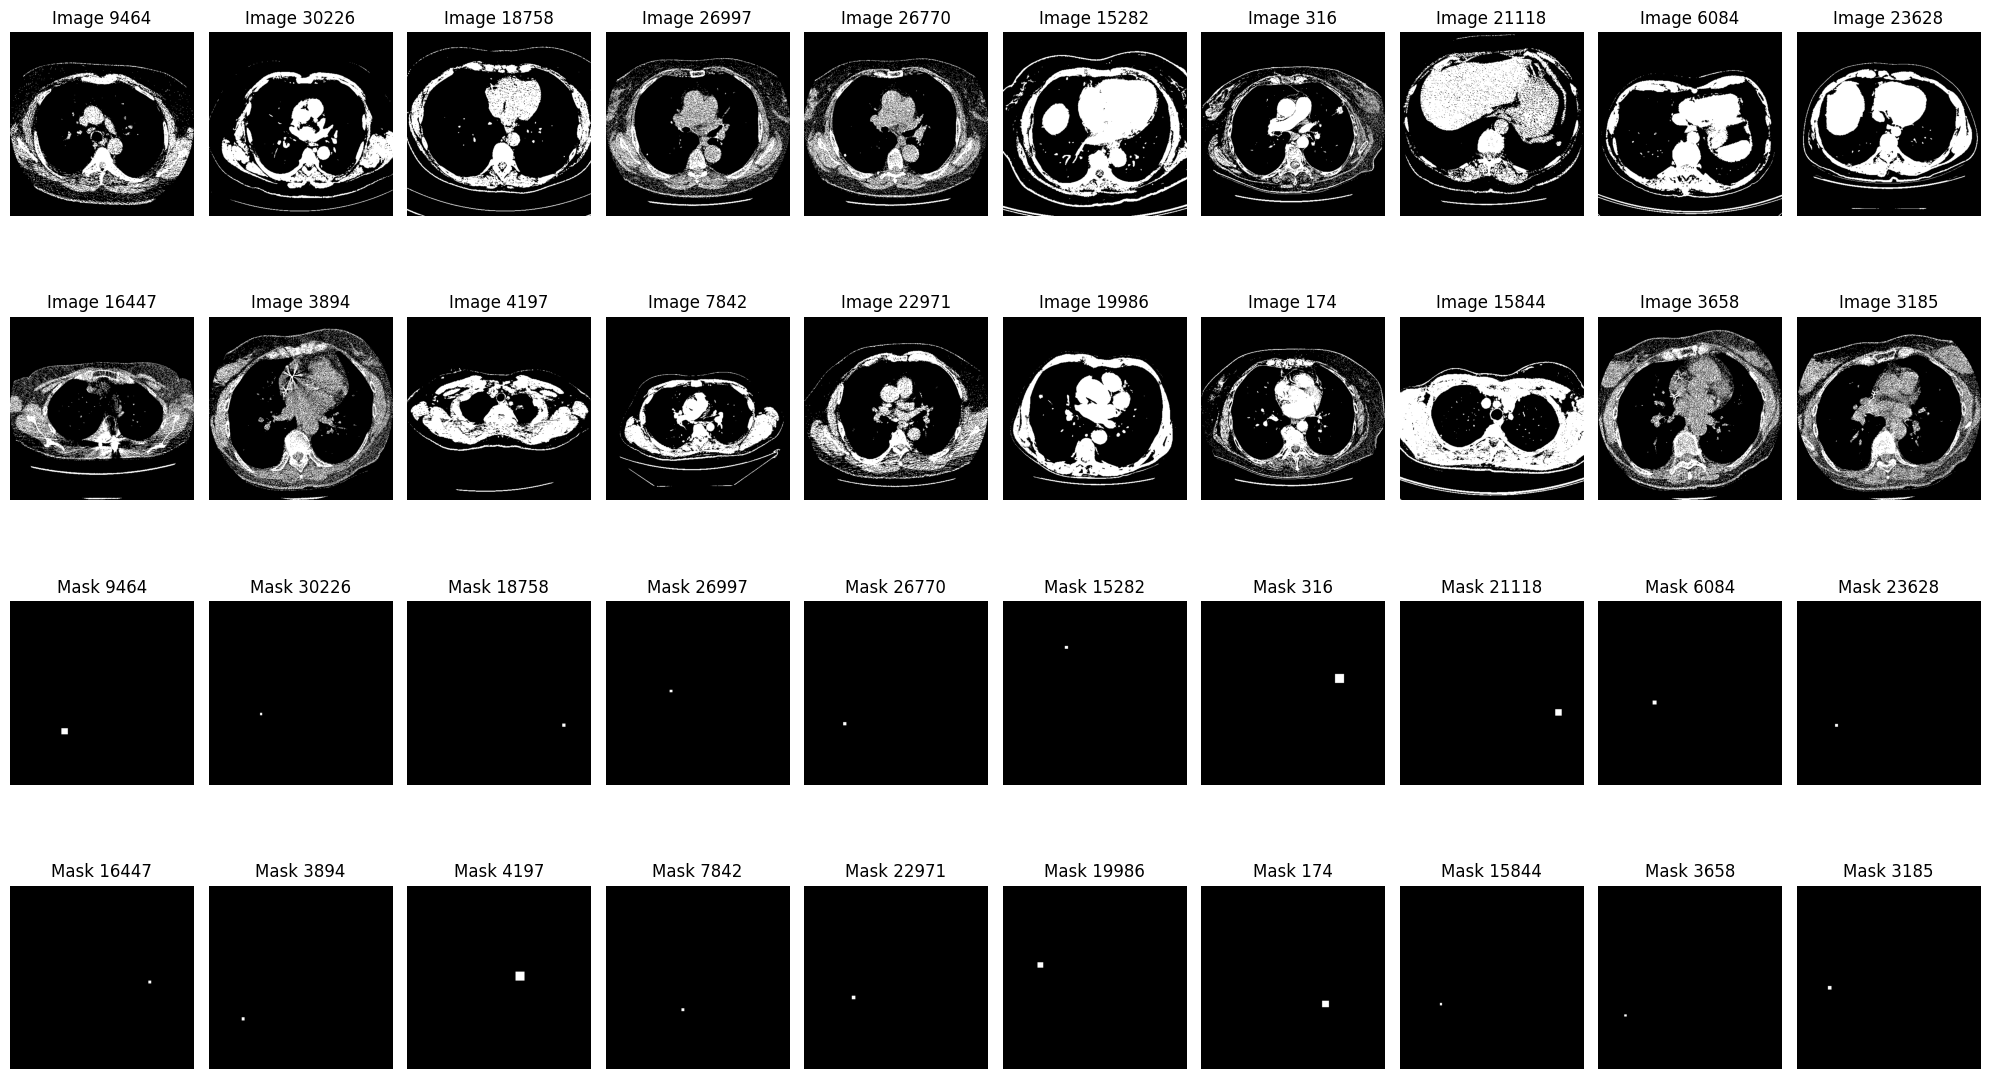

Mask 9464 contains nodule: True
Mask 30226 contains nodule: True
Mask 18758 contains nodule: True
Mask 26997 contains nodule: True
Mask 26770 contains nodule: True
Mask 15282 contains nodule: True
Mask 316 contains nodule: True
Mask 21118 contains nodule: True
Mask 6084 contains nodule: True
Mask 23628 contains nodule: True
Mask 16447 contains nodule: True
Mask 3894 contains nodule: True
Mask 4197 contains nodule: True
Mask 7842 contains nodule: True
Mask 22971 contains nodule: True
Mask 19986 contains nodule: True
Mask 174 contains nodule: True
Mask 15844 contains nodule: True
Mask 3658 contains nodule: True
Mask 3185 contains nodule: True


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

def clip_data(data):
    return np.clip(data, 0, 1)

def visualize_data(original_images, masks, indices):
    plt.figure(figsize=(20, 12))
    num_images = min(20, len(original_images))
    mask_info = []

    for i in range(num_images):
        has_nodule = np.any(masks[i] > 0)
        mask_info.append(has_nodule)

        plt.subplot(4, 10, i + 1)
        plt.imshow(clip_data(np.squeeze(original_images[i])), cmap="gray", vmin=0, vmax=1)
        plt.title(f"Image {indices[i]}")
        plt.axis("off")

        plt.subplot(4, 10, i + 1 + 20)
        plt.imshow(clip_data(np.squeeze(masks[i])), cmap="gray", vmin=0, vmax=1)
        plt.title(f"Mask {indices[i]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    for i, has_nodule in enumerate(mask_info):
        print(f"Mask {indices[i]} contains nodule: {has_nodule}")

def preprocess_image(image):
    if image.ndim == 2:
        image = np.expand_dims(image, axis=-1)
    if image.shape[2] == 1:
        image = np.repeat(image, 3, axis=2)
    image = tf.image.resize(image, (256, 256))
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    return image

def preprocess_mask(mask):
    if mask.ndim == 2:
        mask = np.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, (256, 256))
    mask = tf.cast(mask, tf.float32)
    return mask

def random_data_generator(df, batch_size=20):
    df_with_nodules = df[df['class'] == 1]
    if df_with_nodules.empty:
        raise ValueError("No samples with nodules found in the dataset.")

    indices = np.random.choice(df_with_nodules.index, batch_size, replace=False)
    batch_df = df.loc[indices]
    images = np.array([np.expand_dims(img, axis=0) for img in batch_df['imagedata']])
    masks = np.array([mask for mask in batch_df['maskdata']])
    return images, masks, indices

original_images, masks, indices = random_data_generator(df_slices, batch_size=20)
visualize_data(original_images, masks, indices)


#Model Definition and Custom Dataset

Model Definition: Define the Faster R-CNN model using VGG16 as the backbone.

Includes FPN layers, RPN, and classification/regression heads.

Custom Dataset: Create a custom dataset class for loading image and mask data.

Loss Functions: Define Focal Loss for class imbalance and IoU calculation for evaluation.

Balanced Data Generator: Ensure balanced sampling of nodules and non-nodules.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models import VGG16_Weights
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import torch.multiprocessing as mp
import time

# Set start method for multiprocessing
mp.set_start_method('spawn', force=True)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Focal Loss Definition
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

# Function to calculate Intersection over Union (IoU)
def calculate_iou(box1, box2):
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    box1Area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2Area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    iou = interArea / float(box1Area + box2Area - interArea)
    return iou

# Function to calculate mean Average Precision (mAP)
def calculate_map_score(pred_boxes, true_boxes):
    iou_threshold = 0.5
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    for pred_box, true_box in zip(pred_boxes, true_boxes):
        iou = calculate_iou(pred_box, true_box)
        if (iou >= iou_threshold):
            true_positives += 1
        else:
            false_positives += 1
    false_negatives = len(true_boxes) - true_positives
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    map_score = (precision + recall) / 2
    return map_score, {"precision": precision, "recall": recall}

# Data generator function remains the same
def balanced_data_generator(df, batch_size=20):
    df_with_nodules = df[df['class'] == 1]
    df_without_nodules = df[df['class'] == 0]

    if df_with_nodules.empty:
        raise ValueError("No samples with nodules found in the dataset.")

    nodule_indices = np.random.choice(df_with_nodules.index, batch_size // 2, replace=False)
    non_nodule_indices = np.random.choice(df_without_nodules.index, batch_size // 2, replace=False)

    combined_indices = np.concatenate([nodule_indices, non_nodule_indices])
    np.random.shuffle(combined_indices)

    batch_df = df.loc[combined_indices]
    images = np.array([np.expand_dims(img, axis=0) for img in batch_df['imagedata']])
    masks = np.array([np.expand_dims(mask, axis=0) for mask in batch_df['maskdata']])

    return images, masks, combined_indices

class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = self.df.iloc[idx]['imagedata']
        mask = self.df.iloc[idx]['maskdata']
        class_label = self.df.iloc[idx]['class']

        x = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        y = {
            'rpn_cls': torch.tensor(np.random.randint(0, 2, (64, 64, 18)), dtype=torch.float32).permute(2, 0, 1),  # Shape (18, 64, 64)
            'rpn_reg': torch.tensor(np.random.rand(64, 64, 36), dtype=torch.float32).permute(2, 0, 1),  # Shape (36, 64, 64)
            'classification_head': torch.tensor([class_label], dtype=torch.float32),
            'box_regression_head': torch.tensor(np.random.rand(4), dtype=torch.float32) if class_label == 1 else torch.zeros(4, dtype=torch.float32)
        }
        return x, y

class FasterRCNN(nn.Module):
    def __init__(self):
        super(FasterRCNN, self).__init__()
        self.backbone = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features
        self.backbone[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)  # Adjust for single channel
        self.fpn_p5 = nn.Conv2d(512, 256, kernel_size=1)
        self.fpn_p4 = nn.Conv2d(512, 256, kernel_size=1)
        self.fpn_p3 = nn.Conv2d(256, 256, kernel_size=1)
        self.up_sample = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv3x3_p3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3x3_p4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3x3_p5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.rpn_cls = nn.Conv2d(256, 18, kernel_size=1)
        self.rpn_reg = nn.Conv2d(256, 36, kernel_size=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 16 * 16, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.classification_head = nn.Linear(1024, 1)
        self.box_regression_head = nn.Linear(1024, 4)

    def forward(self, x):
        c3_output = self.backbone[:17](x)  # Up to block3_conv3
        c4_output = self.backbone[17:24](c3_output)  # Up to block4_conv3
        c5_output = self.backbone[24:](c4_output)  # Up to block5_conv3

        p5 = self.fpn_p5(c5_output)
        p4 = self.fpn_p4(c4_output) + self.up_sample(p5)
        p3 = self.fpn_p3(c3_output) + self.up_sample(p4)

        p3 = self.conv3x3_p3(p3)
        p4 = self.conv3x3_p4(p4)
        p5 = self.conv3x3_p5(p5)

        rpn_cls = self.rpn_cls(p3)
        rpn_reg = self.rpn_reg(p3)

        flatten = self.flatten(p5)
        fc1 = F.relu(self.fc1(flatten))
        fc1 = F.dropout(fc1, 0.5)
        fc2 = F.relu(self.fc2(fc1))
        fc2 = F.dropout(fc2, 0.5)

        classification_head = torch.sigmoid(self.classification_head(fc2))
        box_regression_head = self.box_regression_head(fc2)

        return rpn_cls, rpn_reg, classification_head, box_regression_head

# Model Training

Training Function: Define the function to train the model, including loss calculations, gradient scaling, and optimizer updates.

Validation Metrics: Calculate validation metrics such as IoU, mAP, and accuracy.

Data Loaders: Set up data loaders for training and validation.

Model Initialization: Initialize the model and optimizer, then train the model.

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, epochs=30):
    criterion_cls = FocalLoss(logits=True)  # Use focal loss for classification
    criterion_reg = nn.MSELoss()  # Keep MSELoss for regression
    scaler = GradScaler()  # Initialize the gradient scaler for mixed precision

    train_losses = []
    val_iou_scores = []
    val_map_scores = []
    val_accuracy_scores = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode.
        running_loss = 0.0  # Initialize the running loss.
        correct_classifications = 0
        total_samples = 0

        for x_train, y_train in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            optimizer.zero_grad()  # Zero the gradients at the start of a new batch.
            x_train = x_train.to(device)
            y_train = {k: v.to(device) for k, v in y_train.items()}

            with autocast():
                rpn_cls, rpn_reg, cls_head, reg_head = model(x_train)  # Forward pass through the model.

                # Ensure the tensor shapes are correct for loss calculations:
                rpn_cls = rpn_cls.permute(0, 2, 3, 1).contiguous().view(-1, rpn_cls.shape[1])
                rpn_reg = rpn_reg.permute(0, 2, 3, 1).contiguous().view(-1, rpn_reg.shape[1])

                y_train['rpn_cls'] = y_train['rpn_cls'].permute(0, 2, 3, 1).contiguous().view(-1, y_train['rpn_cls'].shape[1])
                y_train['rpn_reg'] = y_train['rpn_reg'].permute(0, 2, 3, 1).contiguous().view(-1, y_train['rpn_reg'].shape[1])

                # Compute the loss for both classification and regression
                loss_cls = criterion_cls(rpn_cls, y_train['rpn_cls'])
                loss_reg = criterion_reg(rpn_reg, y_train['rpn_reg'])
                loss_classification = criterion_cls(cls_head, y_train['classification_head'])
                loss_box_regression = criterion_reg(reg_head, y_train['box_regression_head'])

                total_loss = loss_cls + loss_reg + loss_classification + loss_box_regression

            scaler.scale(total_loss).backward()  # Backpropagation with mixed precision
            scaler.step(optimizer)  # Update weights with scaled gradients
            scaler.update()  # Update the scale for the next iteration
            running_loss += total_loss.item()  # Accumulate the loss

            # Calculate classification accuracy
            preds = (cls_head > 0.5).float()
            correct_classifications += (preds == y_train['classification_head']).sum().item()
            total_samples += preds.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracy = correct_classifications / total_samples

        # Calculate validation metrics
        val_iou, val_map, val_accuracy = calculate_metrics(model, val_loader)
        val_iou_scores.append(val_iou)
        val_map_scores.append(val_map)
        val_accuracy_scores.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}, Val IOU: {val_iou:.4f}, Val mAP: {val_map:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Plotting loss and metrics
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_iou_scores, label='Validation IOU')
    plt.plot(epochs_range, val_map_scores, label='Validation mAP')
    plt.plot(epochs_range, val_accuracy_scores, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('Validation Metrics Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

def calculate_metrics(model, val_loader):
    model.eval()  # Set the model to evaluation mode
    pred_boxes = []
    true_boxes = []
    correct_classifications = 0
    total_samples = 0

    with torch.no_grad():  # No gradient calculation
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = {k: v.to(device) for k, v in y_val.items()}

            _, _, cls_head, reg_head = model(x_val)
            predicted_boxes = reg_head.cpu().numpy()
            actual_boxes = y_val['box_regression_head'].cpu().numpy()

            preds = (cls_head > 0.5).float()
            correct_classifications += (preds == y_val['classification_head']).sum().item()
            total_samples += preds.size(0)

            if len(pred_boxes) == 0:
                pred_boxes = predicted_boxes
                true_boxes = actual_boxes
            else:
                pred_boxes = np.concatenate((pred_boxes, predicted_boxes), axis=0)
                true_boxes = np.concatenate((true_boxes, actual_boxes), axis=0)

    val_iou = np.mean([calculate_iou(pred, true) for pred, true in zip(pred_boxes, true_boxes)])
    val_map, metrics_details = calculate_map_score(pred_boxes, true_boxes)
    val_accuracy = correct_classifications / total_samples

    return val_iou, val_map, val_accuracy

# Initialize and train the model
train_dataset = CustomDataset(df_slices)
val_dataset = CustomDataset(df_slices)  # Define the validation dataset

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)


model = FasterRCNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)
train_model(model, train_loader, val_loader, optimizer, epochs=20)


Epoch 1/20:   0%|          | 0/288 [00:00<?, ?it/s]

ERRORS ANALYSIS:

- COMPUTATIONALLY EXPENSIVE, DIFFICULT TO PERFORM.
- CLASS IMBALANCE
- COMPLEXITY ON IMAGES FOR PREPROCESSING AND AMOUNT OF DATA FOR BOTH CLASSES
- DIFFICULTY ON USING OWN ARCHITECTURES AND NOT PRETRAINED MODELS

##TESTING PART!!!

Test Dataset: Define a dataset class, in this case subset9 for loading test data.

Load Test Data: Load and preprocess all of the subset9 images.

Visualization: Visualize detection results with bounding boxes and scores.

Testing Function: Run the trained model on the test data and visualize predictions.


In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import SimpleITK as sitk
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from glob import glob

# Define a dataset class for the test data
class TestDataset(Dataset):
    def __init__(self, file_list):
        self.file_list = file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        itk_img = sitk.ReadImage(file_path)
        img_array = sitk.GetArrayFromImage(itk_img)
        img_array = (img_array - img_array.min()) / (img_array.max() - img_array.min())
        img_tensor = torch.tensor(img_array, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        return img_tensor, file_path

# Load the test data
subset9_path = "/content/drive/MyDrive/Image Processing/LUNA/subsets/subset9"
file_list = glob(subset9_path + "/*.mhd")

test_dataset = TestDataset(file_list)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)  # Adjust the batch size as needed

# Function to visualize the results
def visualize_detections(images, file_paths, boxes, scores, threshold=0.5):
    batch_size = len(images)
    fig, axes = plt.subplots(batch_size, 2, figsize=(15, 5 * batch_size))

    for i in range(batch_size):
        image = images[i][0].cpu().numpy()
        file_path = file_paths[i]
        box = boxes[i]
        score = scores[i]

        # Normalize the image for visualization
        image = (image - image.min()) / (image.max() - image.min())

        axes[i, 0].imshow(image, cmap='gray')
        axes[i, 0].set_title(f'Image: {file_path}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(image, cmap='gray')
        has_nodule = False
        for b, s in zip(box, score):
            if s > threshold:
                has_nodule = True
                x1, y1, x2, y2 = b
                color = 'red' if s > 0.8 else 'blue'
                rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor=color, linewidth=2)
                axes[i, 1].add_patch(rect)
                axes[i, 1].text(x1, y1, f'{s:.2f}', bbox=dict(facecolor='yellow', alpha=0.5))
        if not has_nodule:
            axes[i, 1].set_title('No Nodule Detected', color='green')
        else:
            axes[i, 1].set_title('Detections')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Function to run the model on the test data and visualize the results
def test_model(model, test_loader, device, threshold=0.5):
    model.eval()
    with torch.no_grad():
        for images, file_paths in tqdm(test_loader, desc="Testing"):
            images = images.to(device)
            rpn_cls, rpn_reg, cls_head, reg_head = model(images)

            # Get the predicted boxes and scores
            boxes = reg_head.cpu().numpy()
            scores = cls_head.cpu().numpy()

            # Visualize the detections
            visualize_detections(images.cpu(), file_paths, boxes, scores, threshold)

# Use the trained model from the current session
model = model.to(device)  # Ensure the model is on the correct device

# Run the test and visualize results
test_model(model, test_loader, device)
